In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
path = '/home/brian/Documents/CPS/data/clean/'

cols = ['LFS', 'BASICWGT', 'PWSSWGT', 'AGE', 'MONTH', 'YEAR', 'FEMALE']

df = pd.concat([pd.read_feather(f'{path}cps{year}.ft', columns=cols) 
                for year in range(1989, 2021)], sort=False)

df['WGT'] = np.where(df['YEAR'] > 1993, df['PWSSWGT'], df['BASICWGT'])
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=1))
data = df.groupby(['DATE', 'LFS']).WGT.sum().unstack().rename({'nan': 'Children'}, axis=1) / 1000000
file = '/home/brian/Documents/uschartbook/chartbook/data/cps_lfs.csv'
data.to_csv(file, index_label='date')

datelt = data.index[-1].strftime('%B %Y')

datepr = f"{data.index[-13].strftime('%B %Y')} to {datelt}"

write_txt(text_dir / 'cps_lfs_date.txt', datelt)

write_txt(text_dir / 'cps_lfs_datepr.txt', datepr)

epop = data["Employed"].iloc[-1] / data.iloc[-1].sum() * 100

In [3]:
text = (f'As of {datelt}, {data["Employed"].iloc[-1]:.1f} million '+
        'people are employed (including self-employment). ')

file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs0.txt'
with open(file, 'w') as wf:
    wf.write(text)


text = ('Labor provided within a household is not captured by GDP compilation '+
        'methods (expenditures, output, or income), though household surveys '+
        'offer some insight into this important category of labor. The '+
        'number of people who are considered employed divided by the total '+
        'population is the employment rate or employment-to-population ratio, '+
        f'which is {epop:.1f} percent as of {datelt}.')


file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs.txt'
with open(file, 'w') as wf:
    wf.write(text)

unemp = (data["Unemployed"].iloc[-1] / (data["Unemployed"].iloc[-1] + data["Employed"].iloc[-1])) * 100
lfpr = (data["Unemployed"].iloc[-1] + data["Employed"].iloc[-1]) / data.iloc[-1].sum() * 100

text = (f'As of {datelt}, there are {data["Unemployed"].iloc[-1]:.1f} million '+
        'unemployed people. The combined group of employed and unemployed people '+
        'is the labor force. The number of unemployed people divided by the number '+
        f'of people in the labor force is the unemployment rate, currently {unemp:.1f} percent. '+
        'The number of people in the labor force divided by the total population is the '+
        f'labor force participation rate, currently {lfpr:.1f} percent.')

text

'As of February 2020, there are 6.4 million unemployed people. The combined group of employed and unemployed people is the labor force. The number of unemployed people divided by the number of people in the labor force is the unemployment rate, currently 3.9 percent. The number of people in the labor force divided by the total population is the labor force participation rate, currently 50.8 percent.'

In [4]:
file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs2.txt'
with open(file, 'w') as wf:
    wf.write(text)
    
cols2 = cols + ['NILFREASON']

datalt = cps_12mo(cps_dir, cps_date(), cols2)

student = (datalt.query('MONTH == 12 and NILFREASON == "School"').PWSSWGT.sum() / 1000000)
care = (datalt.query('MONTH == 12 and NILFREASON == "Family"').PWSSWGT.sum() / 1000000)
disill = (datalt.query('MONTH == 12 and NILFREASON == "Disabled/Ill"').PWSSWGT.sum() / 1000000)
disc = (datalt.query('MONTH == 12 and NILFREASON == "Discouraged"').PWSSWGT.sum() / 1000000)
ret = (datalt.query('MONTH == 12 and NILFREASON == "Retired"').PWSSWGT.sum() / 1000000)

In [5]:
nilfpop = data[['NILF', 'Children']].iloc[-1].sum()
text = ('This category is about half of the population, on average, and '+
        f'totals {nilfpop:.1f} million in {datelt}. The '+
        f'category is comprised of children ({data["Children"].iloc[-1]:.1f}'+
        f' million), students ({student:.1f} million), unpaid caregivers '+
        f'({care:.1f} million), those unable to work due to disability or illness '+
        f'({disill:.1f} million), those who want a job but have given up looking ({disc:.1f} '+
        f'million), and retirees and the elderly ({ret:.1f} million).')

file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs3.txt'
with open(file, 'w') as wf:
    wf.write(text)
    
data['Total'] = data[['Employed', 'Unemployed', 'NILF']].sum(axis=1)
result = data.drop('Children', axis=1).resample('QS').mean()

file = '/home/brian/Documents/uschartbook/chartbook/data/cps_lfs2.csv'
growth_contrib_ann(result, 'Total').to_csv(file, index_label='date')

print(text)

This category is about half of the population, on average, and totals 159.4 million in February 2020. The category is comprised of children (60.4 million), students (19.0 million), unpaid caregivers (12.0 million), those unable to work due to disability or illness (14.6 million), those who want a job but have given up looking (4.3 million), and retirees and the elderly (47.3 million).


### LFS Table

In [6]:
cols = ['LFS', 'PWSSWGT', 'PWSSWGT', 'AGE', 'MONTH', 'YEAR', 'MJH',
        'FEMALE', 'NILFREASON', 'UNEMPTYPE', 'PTECON', 'WORKFT']

df = cps_1mo(cps_dir, cps_date(), cols).query('AGE >= 15')
df2 = cps_1mo(cps_dir, cps_date() - pd.DateOffset(years=1), cols).query('AGE >= 15')

In [7]:
age_groups = [(15, 30), (30, 60), (60, 86)]
sex = [0, 1]
d = {'Population': {'query': 'PWSSWGT > 0'}, 
     '\hspace{2mm}Employed': {'query': 'LFS == "Employed"'}, 
     '\hspace{4mm}Multiple jobs': {'query': 'MJH == 1'},     
     '\hspace{4mm}Full-time': {'query': 'WORKFT == 1'},  
     '\hspace{4mm}Part-time': {'query': 'WORKFT == 0'}, 
     '\hspace{6mm}Economic reasons': {'query': 'PTECON == 1'},
     '\hspace{2mm}Unemployed': {'query': 'LFS == "Unemployed"'}, 
     '\hspace{2mm}Not in Labor Force': {'query': 'LFS == "NILF"'}, 
     '\hspace{4mm}Discouraged': {'query': 'NILFREASON == "Discouraged"'}, 
     '\hspace{4mm}Disabled/Ill': {'query': 'NILFREASON == "Disabled/Ill"'}, 
     '\hspace{4mm}Family/Care': {'query': 'NILFREASON == "Family"'}, 
     '\hspace{4mm}School': {'query': 'NILFREASON == "School"'}, 
     '\hspace{4mm}Retirement': {'query': 'NILFREASON == "Retired"'}}

d2 = {k: {} for k, v in d.items()}

lf_groups = list(zip(d.keys(), [d[i]['query'] for i in d.keys()])) 

for name, query in lf_groups:
    totval = df.query(query).PWSSWGT.sum()/1000
    d[name]['Total, 15+'] = f'{totval:,.0f}'
    chval = totval - df2.query(query).PWSSWGT.sum()/1000
    d2[name]['Total, 15+'] = f'{chval:,.0f}'

for sex, (agemin, agemax) in itertools.product(sex, age_groups):
    data = df.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    data2 = df2.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    group = f'{["Women" if sex==1 else "Men"][0]}, {agemin}--{agemax-1}'.replace('--85', '+')
    for name, query in lf_groups:
        tmp = data.query(query).PWSSWGT.sum()/1000
        tmp2 = data2.query(query).PWSSWGT.sum()/1000
        d[name][group] = f'{tmp:,.0f}'
        d2[name][group] = f'{tmp - tmp2:,.0f}'

In [8]:
file = '/home/brian/Documents/uschartbook/chartbook/data/lfs_table1.tex'
(pd.DataFrame(d).T.drop('query', axis=1).to_csv(file, 
    sep='&', line_terminator='\\\ ', quotechar=' '))
file = '/home/brian/Documents/uschartbook/chartbook/data/lfs_table2.tex'
pd.DataFrame(d2).T.to_csv(file, sep='&', line_terminator='\\\ ', quotechar=' ')

### Employment rates by age, gender, education

In [9]:
cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'AGE', 'EDUC', 'FEMALE']
df1 = pd.read_feather(cps_dir / 'cps2000.ft', columns=cols).query('PWSSWGT > 0')
df2 = cps_12mo(cps_dir, cps_date(), cols)

In [10]:
ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
educ = [['LTHS', 'HS'], ['SC'], ['COLL', 'ADV'], ['LTHS', 'HS', 'SC', 'COLL', 'ADV']]
sex = [0, 1]

In [11]:
results = pd.DataFrame()
for a, e, s in itertools.product(ages, educ, sex):
    row_name = f'{a[0]}-{a[1]}'
    for yr, df in [('2000', df1), ('Latest', df2)]:
        col_name = f'{yr} {" or ".join(e)} {["Female" if s == 1 else "Male"][0]}'
        data = df.query('@a[0] <= AGE <= @a[1] and EDUC in @e and FEMALE == @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, col_name] = (i.Employed / i.sum()) * 100

In [12]:
results.iloc[1:, :-4].to_csv(data_dir / 'empgroups.csv', index_label='name')
results.iloc[:, -4:].to_csv(data_dir / 'empgroups2.csv', index_label='name')

### Union Membership

In [13]:
union_membership_rate = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT'])
union_coverage_rate = lambda x: np.average(x['UNION'], weights=x['PWORWGT'])

unmem, uncov = pd.Series(), pd.Series()

untot, nuntot = pd.Series(), pd.Series()

columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNION', 'UNIONMEM']
for year in range(1989, 2021):
    df = (pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
        .query('LFS == "Employed" and UNION in [0, 1]'))
    data1 = df.groupby(['YEAR', 'MONTH']).apply(union_membership_rate)
    data1.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data1.index]
    unmem = unmem.append(data1)
    data2 = df.groupby(['YEAR', 'MONTH']).apply(union_coverage_rate)
    data2.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data2.index]
    uncov = uncov.append(data2)
    df2 = df.query('UNIONMEM == 1')   
    data3 = df2.groupby(['YEAR', 'MONTH']).PWORWGT.sum()
    data3.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data3.index]
    untot = untot.append(data3)
    df3 = df.query('UNIONMEM == 0')
    data4 = df3.groupby(['YEAR', 'MONTH']).PWORWGT.sum()
    data4.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data4.index]
    nuntot = nuntot.append(data4)    
    
data = pd.DataFrame({'Membership': unmem, 'Coverage': uncov})
levels = pd.DataFrame({'Union': untot, 'Nonunion': nuntot})
data['Diff'] = data['Coverage'] - data['Membership']
final = (data.rolling(12).mean().dropna() * 100)
final.to_csv(data_dir / 'union.csv', index_label='date', float_format='%g')
final2 = (levels.rolling(12).mean().dropna()) / 1000000

ltdate = final.index[-1].strftime('%B %Y')
prevdate = final.index[-13].strftime('%B %Y')
prev2date = final.index[-25].strftime('%B %Y')

ltval = final['Membership'].iloc[-1]
prevval = final['Membership'].iloc[-13]
prev2val = final['Membership'].iloc[-25]

totvallt = final2['Union'].iloc[-1]
totnvallt = final2['Nonunion'].iloc[-1]

chlt = final2['Union'].diff(12).iloc[-1] * 1000000
chpr = final2['Union'].diff(12).iloc[-13] * 1000000

chnlt = final2['Nonunion'].diff(12).iloc[-1] * 1000000
chnpr = final2['Nonunion'].diff(12).iloc[-13] * 1000000

<ipython-input-13-cf3c89eaaab5>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unmem, uncov = pd.Series(), pd.Series()
<ipython-input-13-cf3c89eaaab5>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  untot, nuntot = pd.Series(), pd.Series()


In [14]:
if chlt > 10:
    chlt_txt = f'increased by {round(chlt, -3):,.0f}'
elif chlt <= -10:
    chlt_txt = f'decreased by {abs(round(chlt, -3)):,.0f}'
else:
    chlt_txt = 'were virtually unchanged'
    
if chnlt > 10:
    chnlt_txt = f'increased by {round(chnlt, -3):,.0f}'
elif chnlt <= -10:
    chnlt_txt = f'decreased by {abs(round(chnlt, -3)):,.0f}'
else:
    chnlt_txt = 'were virtually unchanged'

In [15]:
text = (f'Over the 12 months ending {ltdate}, the share of jobs held '+
        f'by union and employee association members averaged {ltval:.1f} percent. '+
        f'In levels, there were {totvallt:.1f} million union jobs, and '+
        f'{totnvallt:.1f} million nonunion jobs, on average over the period. '+
        f'This union membership rate averaged {prevval:.1f} percent during the 12 '+
        f'months ending {prevdate}, and {prev2val:.1f} percent during the 12 '+
        f'months ending {prev2date}. Union jobs {chlt_txt} '+
        f'from {prevdate} to {ltdate}, while nonunion jobs {chnlt_txt}.')

write_txt(text_dir / 'union.txt', text)

text

'Over the 12 months ending February 2020, the share of jobs held by union and employee association members averaged 10.3 percent. In levels, there were 14.6 million union jobs, and 127.4 million nonunion jobs, on average over the period. This union membership rate averaged 10.5 percent during the 12 months ending February 2019, and 10.7 percent during the 12 months ending February 2018. Union jobs decreased by 162,000 from February 2019 to February 2020, while nonunion jobs increased by 1,732,000.'

In [16]:
union_membership_rate = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT']) * 100
columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNIONMEM', 'INDGRP']

df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
                  .query('PWORWGT > 0 and UNIONMEM == UNIONMEM')
      for year in range(1989, 2021)])

df.INDGRP.cat = df.INDGRP.cat.remove_unused_categories()

data = df.groupby(['YEAR', 'MONTH', 'INDGRP']).apply(union_membership_rate).unstack()
data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data.index]
data.index.name = 'date'
data.columns.name = None
prev12 = data.iloc[-12:].mean()
lval = data.iloc[-1]
minval = data.min()
maxval = data.max()
width = maxval - minval
final = pd.concat([lval, prev12, minval, maxval, width], axis=1)
final.columns = ['latest', 'prev12', 'min', 'max', 'width']
final.index.name = 'name'
final = final[['min', 'width', 'latest']].sort_values('latest', ascending=False)
final['y'] = [0.13, -0.87, -1.87, -2.87, -3.87, -4.87, -5.87]
final.to_csv(data_dir / 'union_ind.csv', sep=';')

In [17]:
dec = (maxval - lval).sort_values()
dec1 = dec.index[-1]
decval1 = dec[-1]
decmaxdt = dtxt(data[dec1].idxmax())['mon1']
decmaxval = data[dec1].max()
lowgroupmaxdt = dtxt(data[final.index[-1]].idxmax())['mon1']

text = (f'{final.index[0]} has the highest union membership rate, '+
        f'at {final.latest.iloc[0]:.1f} percent as of {ltdate}, followed by '+
        f'{final.index[1].lower()} with {final.latest.iloc[1]:.1f} percent, '+
        f'and {final.index[2].lower()} with {final.latest.iloc[2]:.1f} percent. '+
        f'The {dec1.lower()} industry '+
        'experienced the largest overall percentage point decrease '+
        'in union membership rates over the past 30 years, and is '+
        f'currently {decval1:.1f} percentage points below its {decmaxdt} '+
        f'rate of {decmaxval:.1f} percent. The lowest union membership rate '+
        f'is in the {final.index[-1].lower()} ({final.latest.iloc[-1]:.1f} percent). '+
        f'The union membership rate of the industry was {data[final.index[-1]].max():.1f} '+
        f'percent at its 30-year peak in {lowgroupmaxdt}. ')

write_txt(text_dir / 'union_ind.txt', text)

text

'Public administration has the highest union membership rate, at 34.2 percent as of February 2020, followed by education and health with 17.1 percent, and construction and mining with 12.8 percent. The leisure and hospitality industry experienced the largest overall percentage point decrease in union membership rates over the past 30 years, and is currently 15.1 percentage points below its January 1989 rate of 18.0 percent. The lowest union membership rate is in the leisure and hospitality (2.9 percent). The union membership rate of the industry was 18.0 percent at its 30-year peak in January 1989. '

### Matching YY -- Disability to Work Flows

Over the year ending February 2020, 8.8 percent of persons age 25--54 who were out of the labor force due to disability or illnessin the prior year are now employed (see {\color{blue}\textbf{---}}). This one-year rate of job-finding has increased substantially from its 2010--2013 average of 5.8 percent


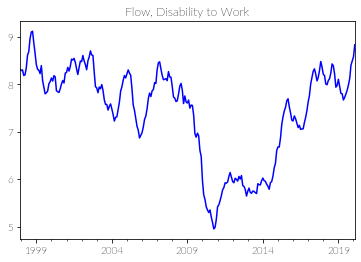

In [18]:
cols = ['CPSID', 'AGE', 'FEMALE', 'WBHAO', 'NILFREASON', 
        'LFS', 'MIS', 'BASICWGT', 'PULINENO']

emp = lambda x: np.where(x.LFS_y == 'Employed', 1, 0)

dates = pd.date_range('1997-01-01', cps_date(), freq='MS')

d = {}

for dt in dates:
    df1 = (cps_1mo(cps_dir, dt - pd.DateOffset(years=1), cols)
           .query('NILFREASON == "Disabled/Ill"'))
    df2 = cps_1mo(cps_dir, dt, cols)
    data = (pd.merge(df1, df2, on=['CPSID', 'PULINENO', 'FEMALE', 'WBHAO'])
              .query('25 <= AGE_y <= 54'))
    data = (data.loc[(data.AGE_x <= data.AGE_y) & 
                     (data.AGE_y - 2 <= data.AGE_x)]).assign(EMP = emp)

    d[dt] = np.average(data.EMP, weights=data.BASICWGT_y) * 100
    
df = pd.Series(d).rolling(12).mean().dropna().rename('Share')

df.to_csv(data_dir / 'disflow.csv', index_label='date', header=True)
write_txt(text_dir/ 'disflow_node.txt', end_node(df, 'blue'))

latest = df.iloc[-1]
valavg = df.loc['2010-12-01':'2013-12-01'].mean()
ltdate = dtxt(df.index[-1])['mon1']

text = (f'Over the year ending {ltdate}, {latest:.1f} percent of '+
        'persons age 25--54 who were out of the labor force due to disability or illness'+
        'in the prior year are now employed (see {\color{blue}\\textbf{---}}). '+
        'This one-year rate of job-finding has increased '+
        f'substantially from its 2010--2013 average of {valavg:.1f} percent')

write_txt(text_dir / 'disflow.txt', text)

print(text)
df.plot(color='blue', title='Flow, Disability to Work');